# first time series

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm

from scipy.stats import jarque_bera
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('fivethirtyeight')

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import seaborn as sns

## Sources
- <a href="https://en.wikipedia.org/wiki/Skewness">skewness</a>
- <a href="https://www.investopedia.com/terms/k/kurtosis.asp">kurtosis</a>
- <a href="https://en.wikipedia.org/wiki/Jarque%E2%80%93Bera_test">Jarque-Bera</a>

In [3]:
def back_y_log(y):
    return np.exp(np.array(y))

In [4]:
def show_plots(y):
    sample = pd.Series(y)
    plt.figure(figsize=(10,6))
    plt.title('Sample')
    plt.xlabel('k')
    plt.ylabel('y')
    plt.plot(sample)
    plt.grid(True)
    plt.show()
    
    plot_pacf(sample, lags=lags);
    plot_acf(sample, lags=lags);

### Calculate metrics

- <a href="https://www.investopedia.com/terms/r/r-squared.asp">R squared</a>
- <a href="https://en.wikipedia.org/wiki/Residual_sum_of_squares">sum_squared_resid</a>
- <a href="https://en.wikipedia.org/wiki/Akaike_information_criterion">AIC</a>
- <a href="https://en.wikipedia.org/wiki/Durbin%E2%80%93Watson_statistic">Duarbin-Watson</a>

In [5]:
def calculate_metrics_sample(y):
    sample = pd.Series(y)
    
    y_dict = {}

    y_dict['series'] = 'Y'
    y_dict['observations'] = sample.size
    y_dict['mode'] = sample.mode()[0]
    y_dict['mean'] = sample.mean()
    y_dict['median'] = sample.median()
    y_dict['variation'] = sample.var()
    y_dict['skewness'] = sample.skew()
    y_dict['kurtosis'] = sample.kurt()
    y_dict['jarque-bera'] = jarque_bera(sample).statistic
    y_dict['probability'] = jarque_bera(sample).pvalue
    
    return y_dict

In [6]:
def claculate_metrics_model_reg(y, y_pred, model_params):
    y , y_pred = np.array(y), np.array(y_pred)
    
    model_arma_metric = {}
    model_arma_metric['r_squared'] = r2_score(y, y_pred) #1 - (np.var(y_pred)/np.var(y))**2
    model_arma_metric['sum_squared_resid'] = sum((y - y_pred)**2)
    model_arma_metric['aic'] = len(y) * np.log(model_arma_metric['sum_squared_resid']) + 2*model_params
    model_arma_metric['durbin_watson'] = durbin_watson(y - y_pred)
    
    return pd.DataFrame(np.array([[metr] for metr in model_arma_metric.values()]).T,
                        columns=['r_squared', 'sum_squared_resid', 'aic','durbin_watson'])

In [7]:
def claculate_metrics_model(y, y_pred, p, q, weight, window, params_ar, params_ma, intercept):
    
    y , y_pred = np.array(y), np.array(y_pred)
    
#     print(f'pred:\t{y_pred}')
#     print(f'y:\t{y}')
    model_params = p + q
    model_arma_metric = {}
    model_arma_metric['name'] = f'ARMA({p,q}) {weight}:{window}'
    model_arma_metric['r_squared'] = r2_score(y, y_pred) #1 - (np.var(y_pred)/np.var(y))**2
    model_arma_metric['sum_squared_resid'] = np.sum((y - y_pred)**2)
    model_arma_metric['aic'] = len(y) * np.log(model_arma_metric['sum_squared_resid'] / len(y)) + 2*model_params
    model_arma_metric['durbin_watson'] = durbin_watson(y - y_pred)
    model_arma_metric['params_ar'] = params_ar
    model_arma_metric['params_ma'] = params_ma
    model_arma_metric['params_intercept'] = intercept
    
    return pd.DataFrame(np.array([[metr] for metr in model_arma_metric.values()]).T, 
                        columns=['name', 'r_squared', 'sum_squared_resid', 'aic','durbin_watson','params_ar', 'params_ma','params_intercept'])

In [8]:
def weight(res, weight, window):
    
    res_copy = res.copy()
    if weight=='simple':
        wma = res_copy.rolling(window=window).mean()
        
        
    elif weight== 'exponential':
        wma = res_copy.ewm(span=window).mean()
    
    else:
        pass
    
    wma[:window] = res_copy[:window]
    return wma

In [9]:
def show_prediction(y, y_pred, name):
    plt.figure(figsize= (15,6.5))
    plt.title(name)
    plt.plot([x for x in range(len(y))],y, label='y')
    plt.plot([x for x in range(len(y) - len(y_pred), len(y))],y_pred, label='y_pred')
    plt.legend()
    plt.show()

In [10]:
def ARMA(p, q, y_, res_, b=None):
    
    df_temp = pd.DataFrame(list(y_), columns=['Value'])
    
    for i in range(1,p+1):
        df_temp[f'Shifted_values_{i}'] = df_temp['Value'].shift(i)
    
    df_train_2 = df_temp.dropna()
#     df_train_2 = df_temp.fillna(0)
    X_train_ar = df_train_2.iloc[:,1:].values.reshape(-1,p)
    y_train_ar = df_train_2.iloc[:,0].values.reshape(-1,1)
    
    lr = LinearRegression()
    lr.fit(X_train_ar,y_train_ar)

    theta_ar  = lr.coef_.T
    intercept_ar = lr.intercept_

    df_train_2['Predicted_Values'] = X_train_ar.dot(theta_ar) + intercept_ar
    
    #----------------
    res = pd.DataFrame(list(res_), columns=['Residuals'])
    for i in range(1,q+1):
         res[f'Shifted_values_{i}'] = res['Residuals'].shift(i)

    res_train_2 = res.dropna()
#     res_train_2 = res.fillna(0)
    X_train_ma = res_train_2.iloc[:,1:].values.reshape(-1,q)
    y_train_ma = res_train_2.iloc[:,0].values.reshape(-1,1)
    
    if b is None:
        lr = LinearRegression()
        lr.fit(X_train_ma,y_train_ma)

        theta_ma  = lr.coef_.T
        intercept_ma = lr.intercept_
    else:
        theta_ma = np.array(b)
        intercept_ma = 0

    res_train_2['Predicted_Values'] = X_train_ma.dot(theta_ma) + intercept_ma

    prediction = pd.DataFrame(res_train_2['Predicted_Values'] + df_train_2['Predicted_Values'],columns=['Predicted_Values'])
#     pred = list(prediction['Predicted_Values'])
    prediction = prediction.dropna()
    pred = [x for x in y_[:max(p,q)]] + list(prediction.Predicted_Values)

    return pred,theta_ar, theta_ma, intercept_ar + intercept_ma

## ARMA

In [27]:
file1 = open('ATS_lab_03_new/Data/rts2.txt')
file_text_1 = file1.read()
y = np.array([float(x) for x in file_text_1.split()])
(len(y))

178

## Зобразимо описові характеристики ряду

In [28]:
lags=40
calculate_metrics_sample(y)

{'series': 'Y',
 'observations': 178,
 'mode': 1441.95,
 'mean': 2383.844325842696,
 'median': 2483.955,
 'variation': 84278.55461564464,
 'skewness': -1.7155134717692684,
 'kurtosis': 2.0883341673064533,
 'jarque-bera': 115.40614985041333,
 'probability': 0.0}

In [29]:
y = pd.Series(y)
y.describe()

count     178.000000
mean     2383.844326
std       290.307690
min      1441.950000
25%      2396.500000
50%      2483.955000
75%      2576.405000
max      2670.610000
dtype: float64

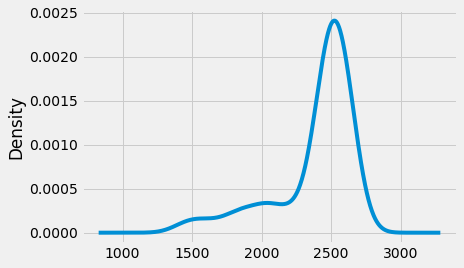

In [30]:
y.plot(kind='kde')

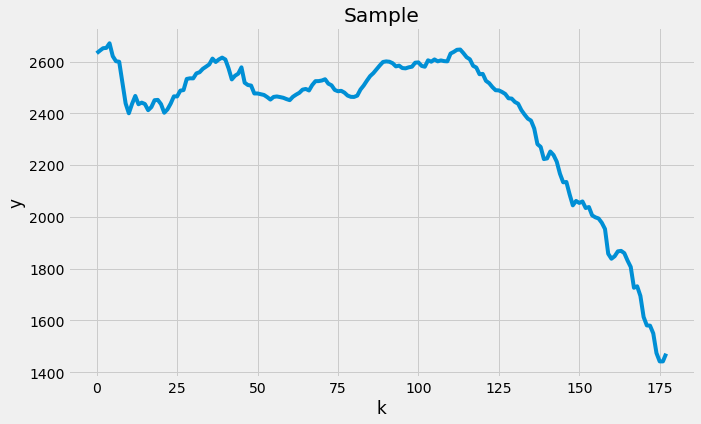

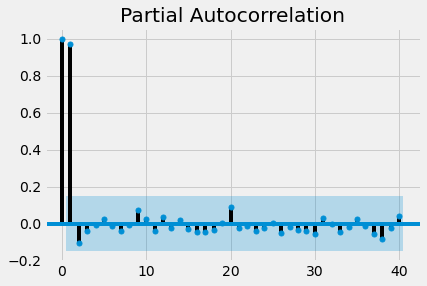

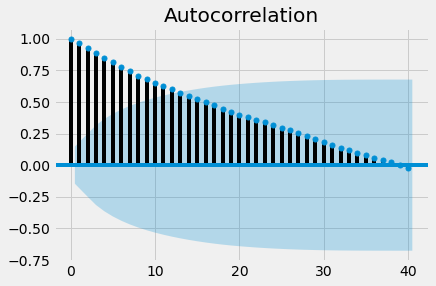

In [31]:
calculate_metrics_sample(y)
show_plots(y)

- [How to choose parameters for ARMA model](https://arauto.readthedocs.io/en/latest/how_to_choose_terms.html)

## ARMA is built by residual 

In [32]:
model = ARIMA(y, order=(12,0,0))
model_fit = model.fit()

print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  178
Model:                    ARMA(12, 0)   Log Likelihood                -801.153
Method:                       css-mle   S.D. of innovations             20.638
Date:                Wed, 04 Nov 2020   AIC                           1630.306
Time:                        21:29:43   BIC                           1674.851
Sample:                             0   HQIC                          1648.370
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2383.8195        nan        nan        nan         nan         nan
ar.L1.y        1.2677   9.63e-06   1.32e+05      0.000       1.268       1.268
ar.L2.y       -0.2034   2.35e-06  -8.65e+04      0.0

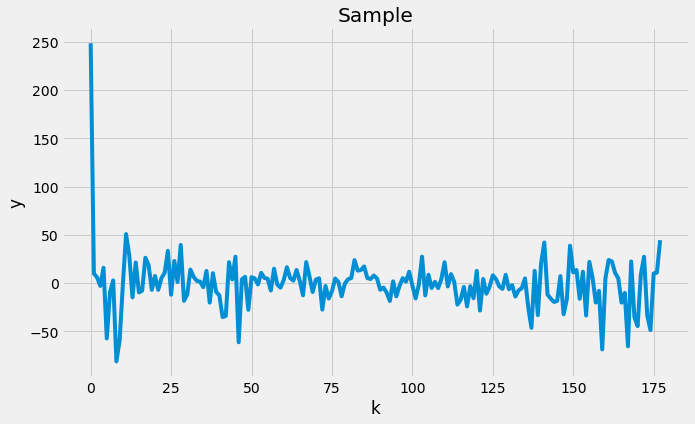

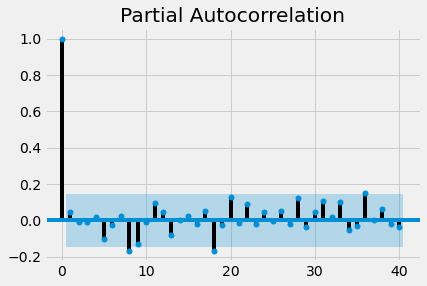

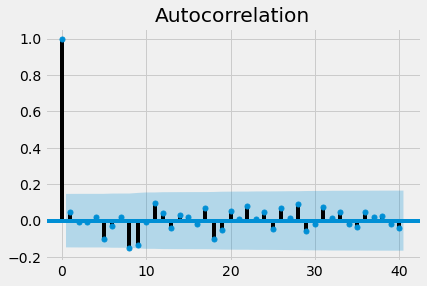

In [33]:
res =  model_fit.resid
show_plots(res)

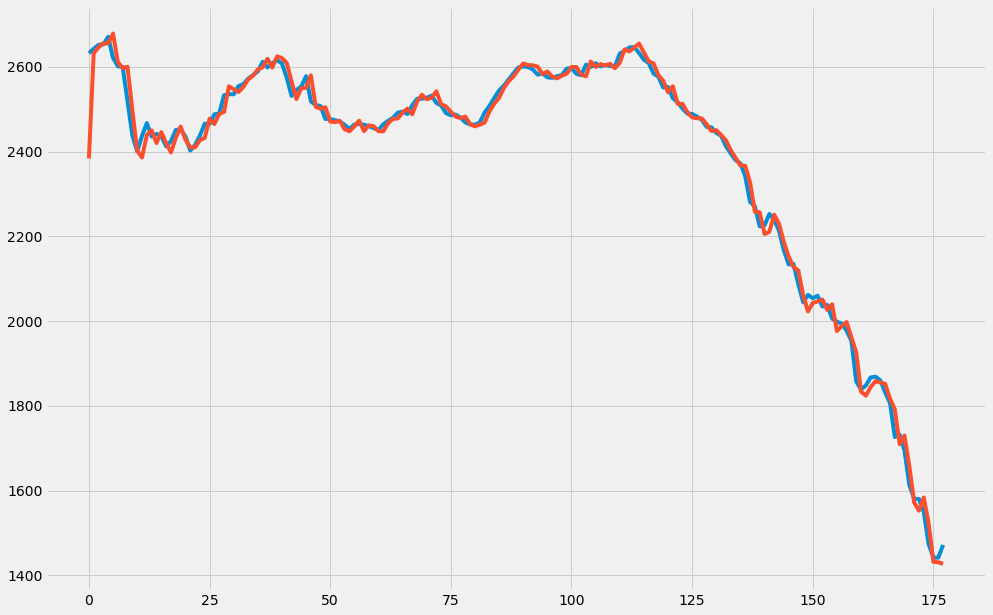

In [34]:
plt.figure(figsize= (15,10))

plt.plot(y)
plt.plot(np.array(model_fit.predict()))

In [35]:
models_metrics = pd.DataFrame(columns=['name', 'r_squared', 'sum_squared_resid', 'aic','durbin_watson','params_ar', 'params_ma','params_intercept'])
predictions_model = []

p, q = 12,36

mv5_simple = weight(res, weight='simple',window=5)
mv10_simple = weight(res, weight='simple',window=10)
mv5_epx = weight(res, weight='exponential',window=5)
mv10_epx = weight(res, weight='exponential',window=10)

# we log input series and now come back to input series
y_back = y

# create prediction and parametrs
pred, params_ar, params_ma, intercept = ARMA(p, q, y - mv5_simple, mv5_simple)

# back prediction to input series take exp()
pred_back = pred 

# calculate metrics for real time series
metrics = claculate_metrics_model(y_back, pred_back, p, q, weight='simple', window=5, params_ar=params_ar, params_ma=params_ma, intercept=intercept)
models_metrics = models_metrics.append(metrics, ignore_index=True)
predictions_model.append(pred_back)


pred, params_ar, params_ma, intercept = ARMA(p, q, y - mv10_simple, mv10_simple)
pred_back = pred 
metrics = claculate_metrics_model(y_back, pred_back, p, q, weight='simple', window=10, params_ar=params_ar, params_ma=params_ma, intercept=intercept)
models_metrics = models_metrics.append(metrics, ignore_index=True)
predictions_model.append(pred_back)

pred, params_ar, params_ma, intercept = ARMA(p, q, y - mv5_epx, mv5_epx)
pred_back = pred 
metrics = claculate_metrics_model(y_back, pred_back, p, q, weight='exponential', window=5, params_ar=params_ar, params_ma=params_ma, intercept=intercept)
models_metrics = models_metrics.append(metrics, ignore_index=True)
predictions_model.append(pred_back)

pred, params_ar, params_ma, intercept = ARMA(p, q, y - mv10_epx, mv10_epx)
pred_back = pred 
metrics = claculate_metrics_model(y_back, pred_back, p, q, weight='exponential', window=10, params_ar=params_ar, params_ma=params_ma, intercept=intercept)
models_metrics = models_metrics.append(metrics, ignore_index=True)
predictions_model.append(pred_back)


## зообразимо отримані метрики готових моделей

In [36]:
models_metrics

,name,r_squared,sum_squared_resid,aic,durbin_watson,params_ar,params_ma,params_intercept
0,"ARMA((12, 36)) simple:5",0.992124,117494,1251.64,1.28338,"[[1.2231779511975867], [-0.19357122460595197],...","[[0.9787393853627009], [-0.012649631615312363]...",[-22.205598386882617]
1,"ARMA((12, 36)) simple:10",0.991399,128305,1267.31,1.32437,"[[1.2320916542350961], [-0.22533882032107566],...","[[0.9385534085412531], [0.05659885862864642], ...",[-25.334148944795498]
2,"ARMA((12, 36)) exponential:5",0.992521,111569,1242.43,1.28584,"[[1.4546296762722837], [-0.4923948770471077], ...","[[0.627148491949212], [0.05476222018160568], [...",[-17.64104946112287]
3,"ARMA((12, 36)) exponential:10",0.991479,127107,1265.64,1.34076,"[[1.2957991886034324], [-0.29522634839748585],...","[[0.7619168951953299], [0.050362890170085196],...",[-24.803213934010245]


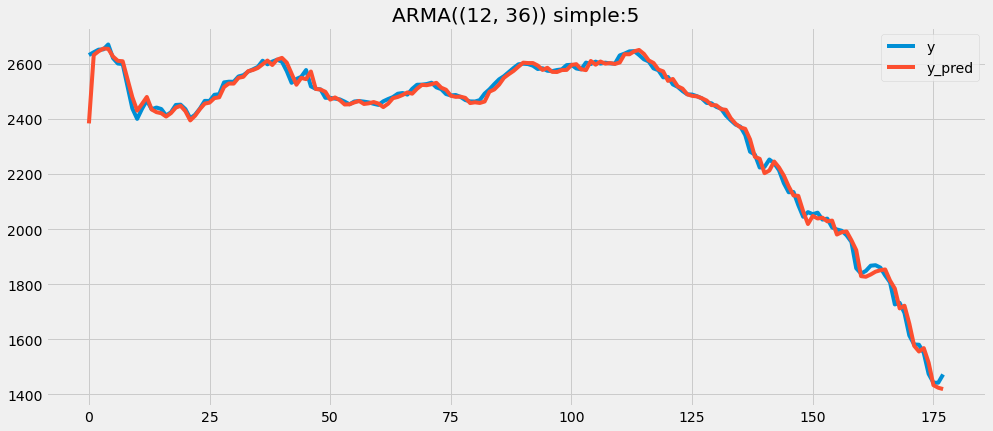

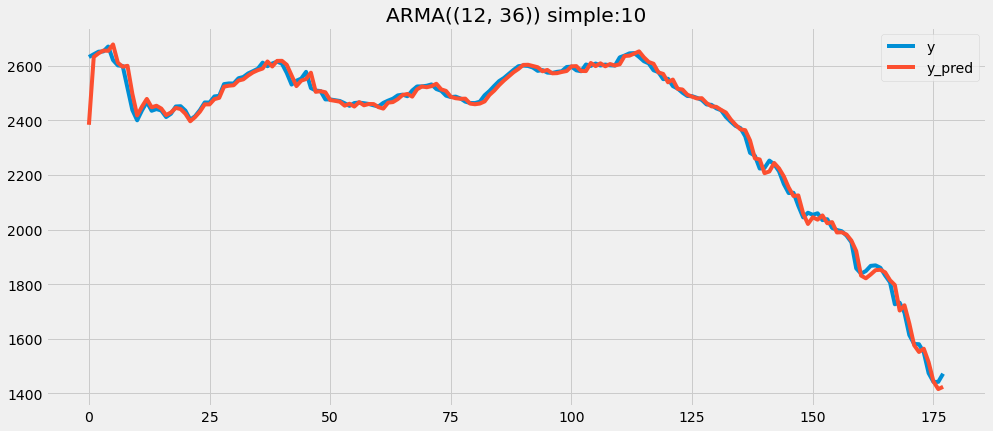

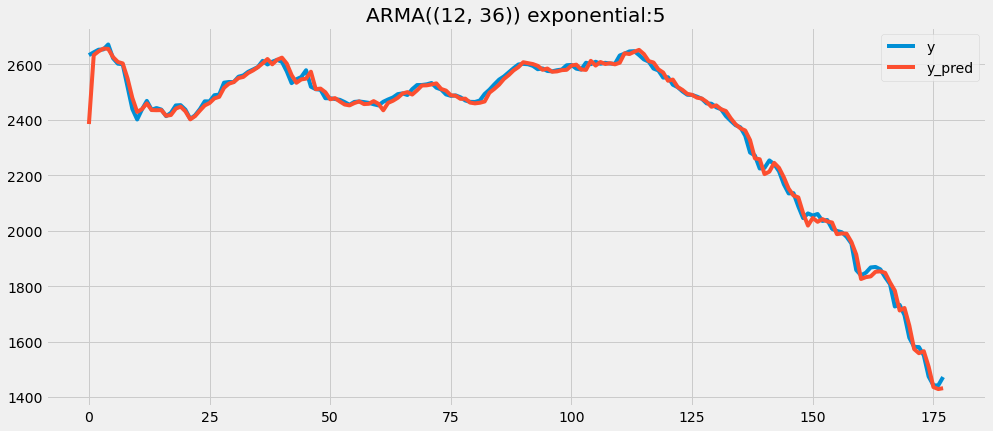

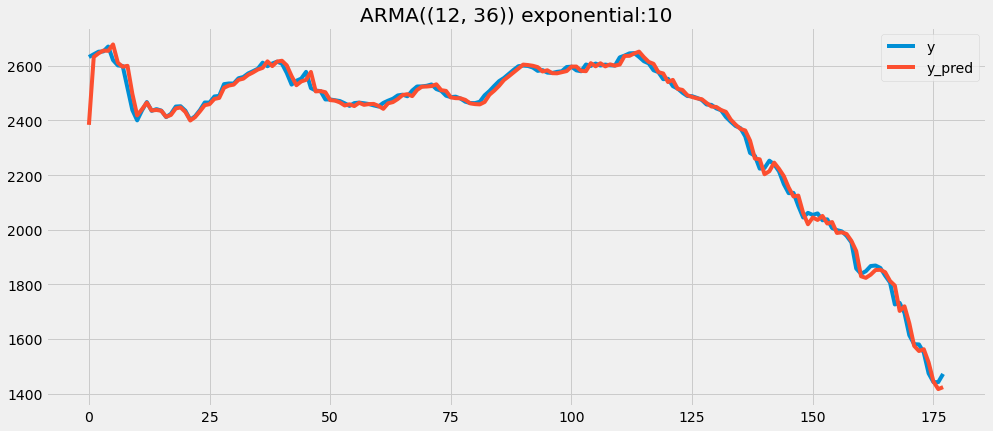

In [37]:
for name, y_pred in zip(models_metrics.name, predictions_model):
    show_prediction(y_back, y_pred, name)

In [67]:
models_metrics.to_excel('result/table_2.xls')

## 2. Побудова ARMA(p,q) коли КС будується по вихідному сигналу у 

## Власні коефіцієнти

In [38]:
def know_b(y, mv,q, window):
    a = 2/(window+1)
    s = sum([(1-a)**i for i in range(1, q+1)])
    b = [(1/s)*((1-a)**i) for i in range(1, q+1)]
    y_new = []
    for i in range(len(y)):
        s = y[i]-mv[i]
        
        for j in range(q):
            if( i - j -1 > -1):
                s += -mv[i-j-1]*b[j]
        y_new.append(s)
        
    return y_new, b

## продиференціюємо ряд, оскільки метод не працює з нестаціонарним рядо

In [39]:
def adf_check(time_series):
    """
    Pass in a time series, return ADF report
    """
    
    result = adfuller(time_series)
    print('Augmented Dickey-Fuller Test')
    
    labels = ['ADF Test Statistic','p-value','Number of Lags Used','Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary \n")

In [40]:
def back_y_diff(y_old, y, pred, period=1):
    df = pd.DataFrame({'Value': y_old})
    df_c = pd.DataFrame({'Value': y, 'Predicted_Value': pred}).dropna()

    df_c.Value += df.Value
    df_c.Value += df.diff(period).Value
    df_c.Predicted_Value += df.Value
    df_c.Predicted_Value += df.diff(period).Value

    df_c = df_c.dropna()
    
    return y_old[len(y_old) - len(df_c.Value):], df_c.Value, df_c.Predicted_Value

In [51]:
file1 = open('2006rts1.txt')
file_text_1 = file1.read()
y = np.array([float(x) for x in file_text_1.split()])

diff_y = pd.DataFrame(y).diff().dropna()

# test = sm.tsa.adfuller(diff_y)
# print(f'test:\n{test}')
y_old = y
# y = np.array(diff_y.values)
y = np.array(diff_y).reshape(1,-1)[0]
calculate_metrics_sample(y)

{'series': 'Y',
 'observations': 247,
 'mode': -11.759999999999991,
 'mean': 2.9618623481781383,
 'median': 4.789999999999964,
 'variation': 850.0868908265046,
 'skewness': -0.9874197182300382,
 'kurtosis': 3.5872609464208014,
 'jarque-bera': 165.06596801222767,
 'probability': 0.0}

In [52]:
adf_check(y)

Augmented Dickey-Fuller Test
ADF Test Statistic : -14.714564802107095
p-value : 2.8131780680771376e-27
Number of Lags Used : 0
Number of Observations Used : 246
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


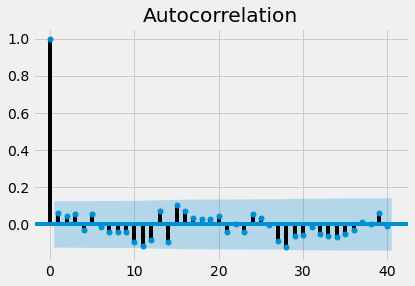

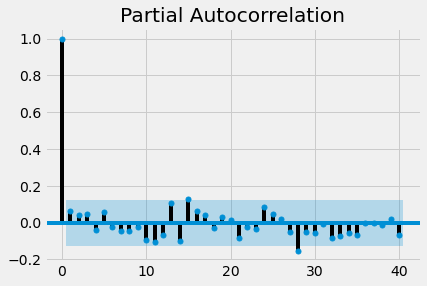

In [53]:
plot_acf(y, lags=lags);
plot_pacf(y, lags=lags);

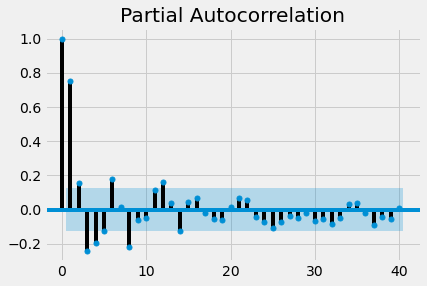

In [54]:
models_metrics_1 = pd.DataFrame(columns=['name', 'r_squared', 'sum_squared_resid', 'aic','durbin_watson','params_ar', 'params_ma','params_intercept'])
predictions_model_aprox = pd.DataFrame(columns=['name', 'r_squared', 'sum_squared_resid', 'aic','durbin_watson','params_ar', 'params_ma','params_intercept'])
predictions_model_1 = []

window = 5
mv5_simple = weight(pd.DataFrame(y), weight='simple',window=window)

plot_pacf(pd.Series(mv5_simple[0]), lags=lags);

In [55]:
p,q=11, 14
y_new2, b2 = know_b(y, mv5_simple[0], q, window)
pred, params_ar, params_ma, intercept = ARMA(p, q, y_new2, mv5_simple[0], b2)

y_real, y_aprox, pred = back_y_diff(y_old, y, pred)

metrics = claculate_metrics_model(y_real, pred, p, q, weight='simple', window=window, params_ar=params_ar, params_ma=params_ma, intercept=intercept)
metrics_aprox = claculate_metrics_model(y_aprox, pred, p, q, weight='simple', window=window, params_ar=params_ar, params_ma=params_ma, intercept=intercept)

models_metrics_1 = models_metrics_1.append(metrics, ignore_index=True)
predictions_model_aprox = predictions_model_aprox.append(metrics_aprox, ignore_index=True)

predictions_model_1.append(pred)
metrics

,name,r_squared,sum_squared_resid,aic,durbin_watson,params_ar,params_ma,params_intercept
0,"ARMA((11, 14)) simple:5",0.916153,486581,1917.1,2.79103,"[[0.21203264089227342], [0.08585063629228648],...","[0.33447908722911684, 0.22298605815274458, 0.1...",[-2.8514445752741793]


In [56]:
# plt.figure(figsize=(15,7.5))
# plt.plot(y_aprox, color='blue', label='y_diff')
# plt.plot(pred, color='yellow', label='y_pred')
# plt.plot(y_real, color='red', label='y')
# plt.legend()
# plt.show()

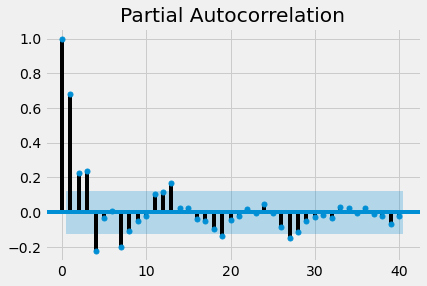

In [57]:
window = 10
mv10_simple = weight(pd.DataFrame(y), weight='simple',window=window)
plot_pacf(mv10_simple, lags=lags);

In [58]:
q=27
y_new2, b2 = know_b(y, mv10_simple[0], q, window)
pred, params_ar, params_ma, intercept = ARMA(p, q, y_new2, mv10_simple[0], b2)

y_real, y_aprox, pred = back_y_diff(y_old, y, pred)

metrics = claculate_metrics_model(y_real, pred, p, q, weight='simple', window=window, params_ar=params_ar, params_ma=params_ma, intercept=intercept)
metrics_aprox = claculate_metrics_model(y_aprox, pred, p, q, weight='simple', window=window, params_ar=params_ar, params_ma=params_ma, intercept=intercept)

models_metrics_1 = models_metrics_1.append(metrics, ignore_index=True)
predictions_model_aprox = predictions_model_aprox.append(metrics_aprox, ignore_index=True)

predictions_model_1.append(pred)
metrics

,name,r_squared,sum_squared_resid,aic,durbin_watson,params_ar,params_ma,params_intercept
0,"ARMA((11, 27)) simple:10",0.921862,453449,1925.75,2.78338,"[[0.15168152431075274], [0.1043207122639254], ...","[0.18262823433543018, 0.1494231008198974, 0.12...",[-2.687792721466262]


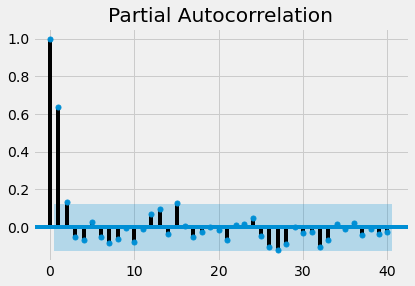

In [59]:
window = 5
mv5_exp = weight(pd.DataFrame(y), weight='exponential',window=window)
plot_pacf(mv5_exp, lags=lags);

In [60]:
q=27
y_new2, b2 = know_b(y, mv5_exp[0], q, window)
pred, params_ar, params_ma, intercept = ARMA(p, q, y_new2, mv5_exp[0], b2)

y_real, y_aprox, pred = back_y_diff(y_old, y, pred)

metrics = claculate_metrics_model(y_real, pred, p, q, weight='exponential', window=window, params_ar=params_ar, params_ma=params_ma, intercept=intercept)
metrics_aprox = claculate_metrics_model(y_aprox, pred, p, q, weight='exponential', window=window, params_ar=params_ar, params_ma=params_ma, intercept=intercept)

models_metrics_1 = models_metrics_1.append(metrics, ignore_index=True)
predictions_model_aprox = predictions_model_aprox.append(metrics_aprox, ignore_index=True)

predictions_model_1.append(pred)
metrics

,name,r_squared,sum_squared_resid,aic,durbin_watson,params_ar,params_ma,params_intercept
0,"ARMA((11, 27)) exponential:5",0.91951,467096,1933.04,2.76219,"[[0.13142736416253964], [0.06858645986246545],...","[0.3333392004185317, 0.2222261336123545, 0.148...",[-2.6102737527456275]


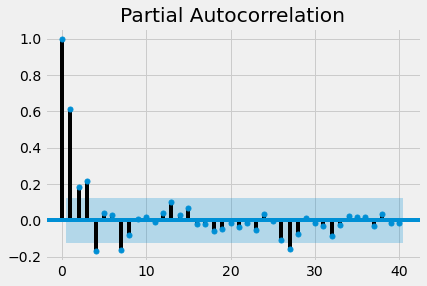

In [61]:
window = 10
mv10_exp = weight(pd.DataFrame(y), weight='exponential',window=window)
plot_pacf(mv10_exp, lags=lags);

In [62]:
q=27
y_new2, b2 = know_b(y, mv10_exp[0], q, window)
pred, params_ar, params_ma, intercept = ARMA(p, q, y_new2, mv10_exp[0], b2)

y_real, y_aprox, pred = back_y_diff(y_old, y, pred)

metrics = claculate_metrics_model(y_real, pred, p, q, weight='exponential', window=window, params_ar=params_ar, params_ma=params_ma, intercept=intercept)
metrics_aprox = claculate_metrics_model(y_aprox, pred, p, q, weight='exponential', window=window, params_ar=params_ar, params_ma=params_ma, intercept=intercept)

models_metrics_1 = models_metrics_1.append(metrics, ignore_index=True)
predictions_model_aprox = predictions_model_aprox.append(metrics_aprox, ignore_index=True)

predictions_model_1.append(pred)
metrics

,name,r_squared,sum_squared_resid,aic,durbin_watson,params_ar,params_ma,params_intercept
0,"ARMA((11, 27)) exponential:10",0.925712,431107,1913.32,2.83416,"[[0.0975622065373188], [0.06594295107868713], ...","[0.18262823433543018, 0.1494231008198974, 0.12...",[-2.7077601414234205]


## Description
Стало цікаво що ми втрачаємо при поверненні назад до реального ряду, тому зообразили метрики для ряду який бува заданий та для диференційованого

## зообразимо отримані метрики готових моделей 
###  за y взяті реальні занчення

In [63]:
models_metrics_1

,name,r_squared,sum_squared_resid,aic,durbin_watson,params_ar,params_ma,params_intercept
0,"ARMA((11, 14)) simple:5",0.916153,486581,1917.1,2.79103,"[[0.21203264089227342], [0.08585063629228648],...","[0.33447908722911684, 0.22298605815274458, 0.1...",[-2.8514445752741793]
1,"ARMA((11, 27)) simple:10",0.921862,453449,1925.75,2.78338,"[[0.15168152431075274], [0.1043207122639254], ...","[0.18262823433543018, 0.1494231008198974, 0.12...",[-2.687792721466262]
2,"ARMA((11, 27)) exponential:5",0.91951,467096,1933.04,2.76219,"[[0.13142736416253964], [0.06858645986246545],...","[0.3333392004185317, 0.2222261336123545, 0.148...",[-2.6102737527456275]
3,"ARMA((11, 27)) exponential:10",0.925712,431107,1913.32,2.83416,"[[0.0975622065373188], [0.06594295107868713], ...","[0.18262823433543018, 0.1494231008198974, 0.12...",[-2.7077601414234205]


## зообразимо отримані метрики готових моделей 
### (за y взятий перетворені назад диференційовані занчення)

In [64]:
predictions_model_aprox

,name,r_squared,sum_squared_resid,aic,durbin_watson,params_ar,params_ma,params_intercept
0,"ARMA((11, 14)) simple:5",0.964496,222085,1724.15,2.15735,"[[0.21203264089227342], [0.08585063629228648],...","[0.33447908722911684, 0.22298605815274458, 0.1...",[-2.8514445752741793]
1,"ARMA((11, 27)) simple:10",0.96594,213052,1739.93,2.0235,"[[0.15168152431075274], [0.1043207122639254], ...","[0.18262823433543018, 0.1494231008198974, 0.12...",[-2.687792721466262]
2,"ARMA((11, 27)) exponential:5",0.965835,213714,1740.7,2.08305,"[[0.13142736416253964], [0.06858645986246545],...","[0.3333392004185317, 0.2222261336123545, 0.148...",[-2.6102737527456275]
3,"ARMA((11, 27)) exponential:10",0.966475,209708,1736.04,1.97437,"[[0.0975622065373188], [0.06594295107868713], ...","[0.18262823433543018, 0.1494231008198974, 0.12...",[-2.7077601414234205]


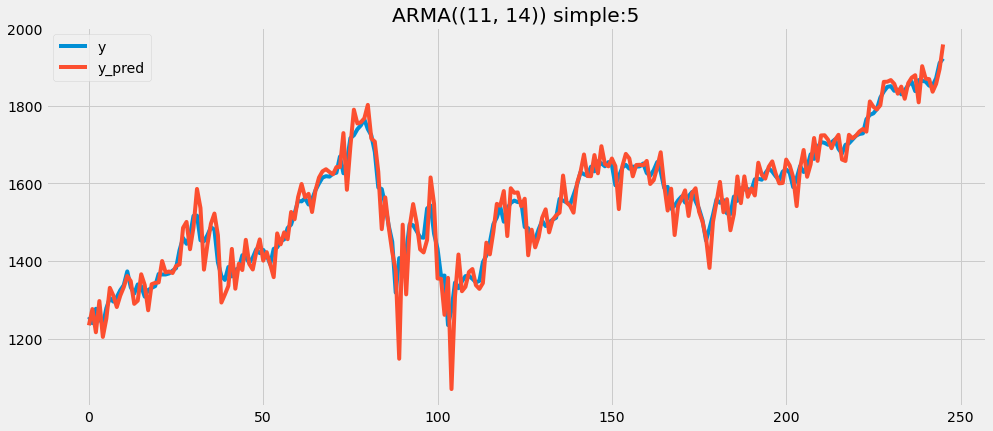

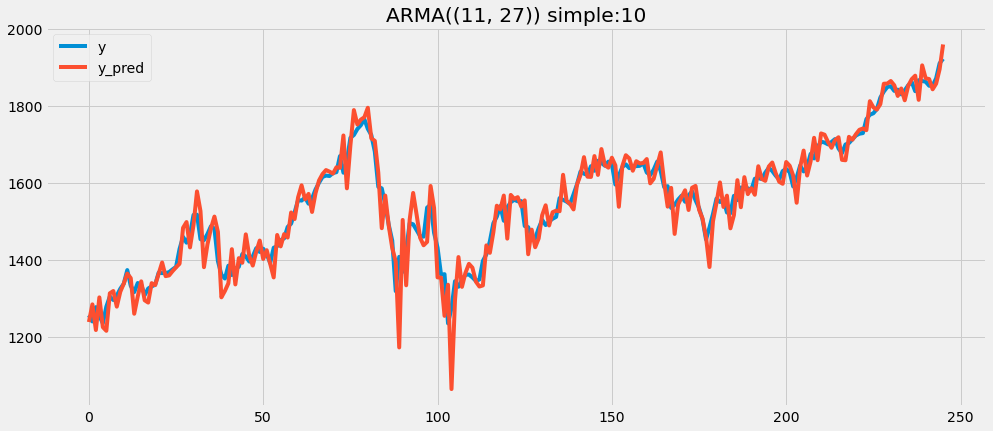

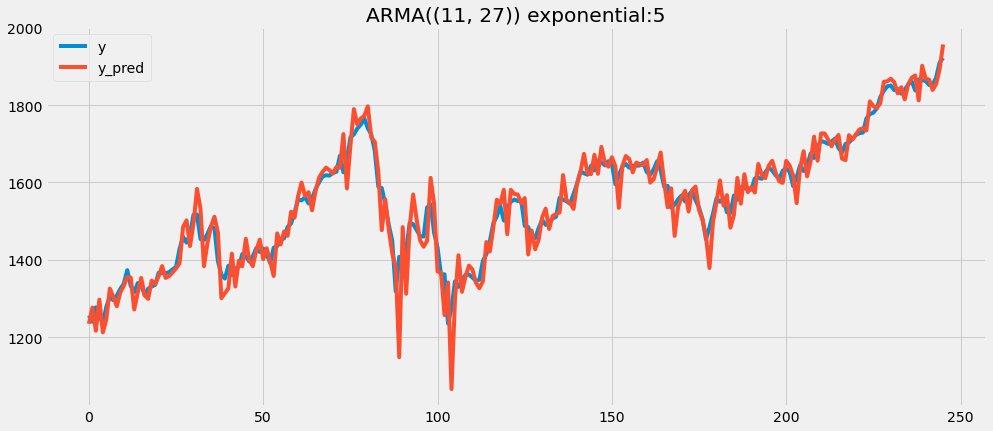

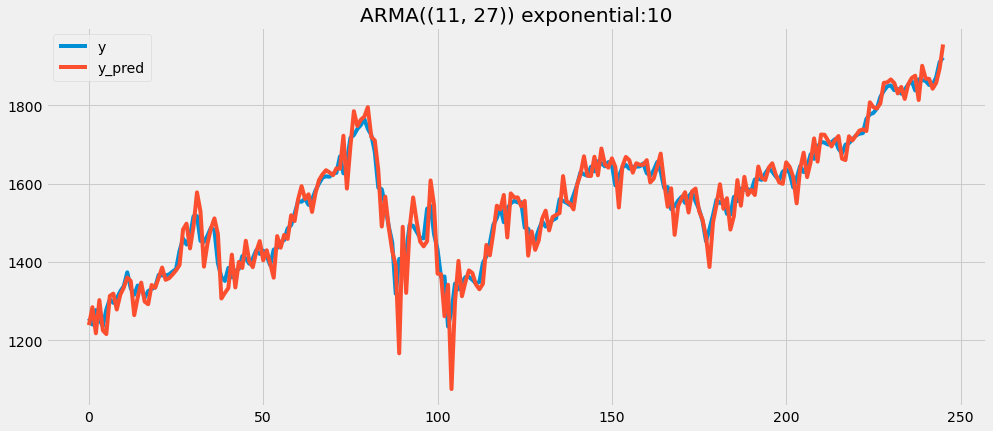

In [65]:
for name, y_pred in zip(models_metrics_1.name, predictions_model_1):
    show_prediction(y_real, y_pred, name)

In [66]:
models_metrics_1.to_excel('result/table_2_2.xls')
predictions_model_aprox.to_excel('result/table_2_aprox_2.xls')

## Обчислення коефіцієнтів 

In [68]:
models_metrics_2 = pd.DataFrame(columns=['name', 'r_squared', 'sum_squared_resid', 'aic','durbin_watson','params_ar', 'params_ma','params_intercept'])
predictions_model_aprox_2 = pd.DataFrame(columns=['name', 'r_squared', 'sum_squared_resid', 'aic','durbin_watson','params_ar', 'params_ma','params_intercept'])

predictions_model_2 = []

q = 14
pred, params_ar, params_ma, intercept = ARMA(p, q, y - mv5_simple[0], mv5_simple[0])
y_real, y_aprox, pred = back_y_diff(y_old, y, pred)

metrics = claculate_metrics_model(y_real, pred, p, q, weight='simple', window=5, params_ar=params_ar, params_ma=params_ma, intercept=intercept)
metrics_aprox = claculate_metrics_model(y_aprox, pred, p, q, weight='simple', window=5, params_ar=params_ar, params_ma=params_ma, intercept=intercept)

models_metrics_2 = models_metrics_2.append(metrics, ignore_index=True)
predictions_model_aprox_2 = predictions_model_aprox_2.append(metrics_aprox, ignore_index=True)
predictions_model_2.append(pred)


q = 27
pred, params_ar, params_ma, intercept = ARMA(p, q, y - mv10_simple[0], mv10_simple[0])
y_real, y_aprox, pred = back_y_diff(y_old, y, pred)

metrics = claculate_metrics_model(y_real, pred, p, q, weight='simple', window=10, params_ar=params_ar, params_ma=params_ma, intercept=intercept)
metrics_aprox = claculate_metrics_model(y_aprox, pred, p, q, weight='simple', window=10, params_ar=params_ar, params_ma=params_ma, intercept=intercept)

models_metrics_2 = models_metrics_2.append(metrics, ignore_index=True)
predictions_model_aprox_2 = predictions_model_aprox_2.append(metrics_aprox, ignore_index=True)
predictions_model_2.append(pred)

q = 27
pred, params_ar, params_ma, intercept = ARMA(p, q, y - mv5_exp[0], mv5_exp[0])
y_real, y_aprox, pred = back_y_diff(y_old, y, pred)

metrics = claculate_metrics_model(y_real, pred, p, q, weight='exponential', window=5, params_ar=params_ar, params_ma=params_ma, intercept=intercept)
metrics_aprox = claculate_metrics_model(y_aprox, pred, p, q, weight='exponential', window=5, params_ar=params_ar, params_ma=params_ma, intercept=intercept)

models_metrics_2 = models_metrics_2.append(metrics, ignore_index=True)
predictions_model_aprox_2 = predictions_model_aprox_2.append(metrics_aprox, ignore_index=True)
predictions_model_2.append(pred)

q = 27
pred, params_ar, params_ma, intercept = ARMA(p, q, y - mv10_exp[0], mv10_exp[0])
y_real, y_aprox, pred = back_y_diff(y_old, y, pred)

metrics = claculate_metrics_model(y_real, pred, p, q, weight='exponential', window=10, params_ar=params_ar, params_ma=params_ma, intercept=intercept)
metrics_aprox = claculate_metrics_model(y_aprox, pred, p, q, weight='exponential', window=10, params_ar=params_ar, params_ma=params_ma, intercept=intercept)

models_metrics_2 = models_metrics_2.append(metrics, ignore_index=True)
predictions_model_aprox_2 = predictions_model_aprox_2.append(metrics_aprox, ignore_index=True)

predictions_model_2.append(pred)

## зообразимо отримані метрики готових моделей
###  за y взяті реальні занчення

In [69]:
models_metrics_2

,name,r_squared,sum_squared_resid,aic,durbin_watson,params_ar,params_ma,params_intercept
0,"ARMA((11, 14)) simple:5",0.925568,431942,1887.8,2.82096,"[[-0.0979185517639832], [-0.13981382252444505]...","[[0.9925226641769489], [0.0042736272316355964]...",[0.6114672257919906]
1,"ARMA((11, 27)) simple:10",0.926256,427950,1911.51,2.82124,"[[-0.0012187209435645019], [-0.016574320430677...","[[1.015575376572667], [0.00301119493958302], [...",[0.3757836802726758]
2,"ARMA((11, 27)) exponential:5",0.928029,417662,1905.53,2.84579,"[[-0.1943233236959], [-0.16377092471725643], [...","[[0.7245284127576611], [0.0008831519076147194]...",[0.9961932258121984]
3,"ARMA((11, 27)) exponential:10",0.927644,419898,1906.84,2.84542,"[[-0.07077616405989602], [-0.06501149999585995...","[[0.8636426847066756], [0.0014474059671747597]...",[0.5797996698116581]


## зообразимо отримані метрики готових моделей 
### (за y взятий перетворені назад диференційовані занчення)

In [70]:
predictions_model_aprox_2

,name,r_squared,sum_squared_resid,aic,durbin_watson,params_ar,params_ma,params_intercept
0,"ARMA((11, 14)) simple:5",0.967135,205579,1705.15,2.0646,"[[-0.0979185517639832], [-0.13981382252444505]...","[[0.9925226641769489], [0.0042736272316355964]...",[0.6114672257919906]
1,"ARMA((11, 27)) simple:10",0.968256,198564,1722.61,2.0407,"[[-0.0012187209435645019], [-0.016574320430677...","[[1.015575376572667], [0.00301119493958302], [...",[0.3757836802726758]
2,"ARMA((11, 27)) exponential:5",0.96939,191476,1713.67,2.06556,"[[-0.1943233236959], [-0.16377092471725643], [...","[[0.7245284127576611], [0.0008831519076147194]...",[0.9961932258121984]
3,"ARMA((11, 27)) exponential:10",0.968746,195500,1718.78,2.04894,"[[-0.07077616405989602], [-0.06501149999585995...","[[0.8636426847066756], [0.0014474059671747597]...",[0.5797996698116581]


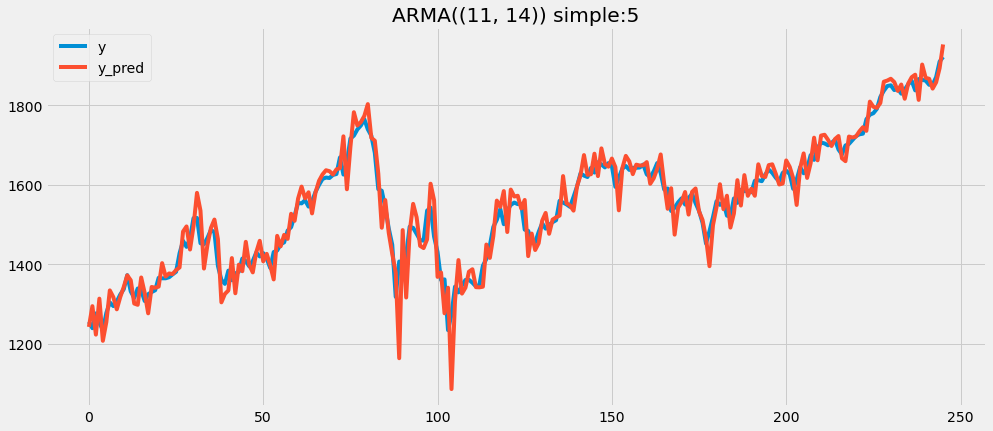

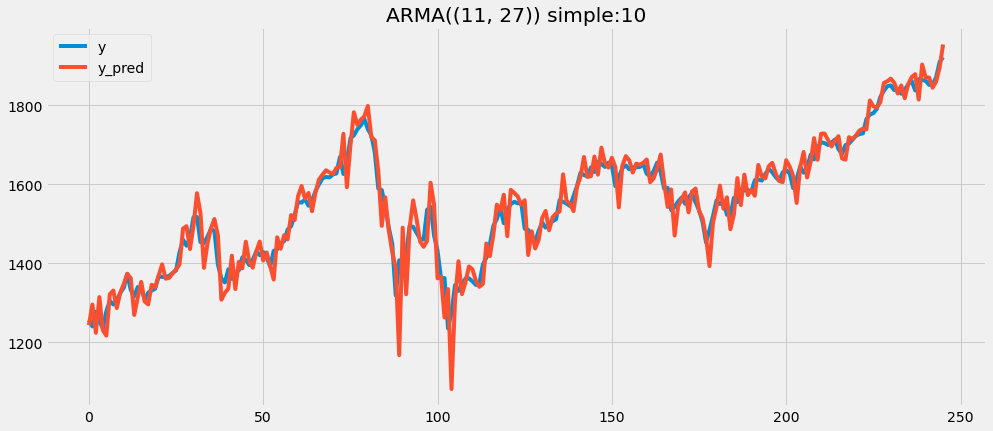

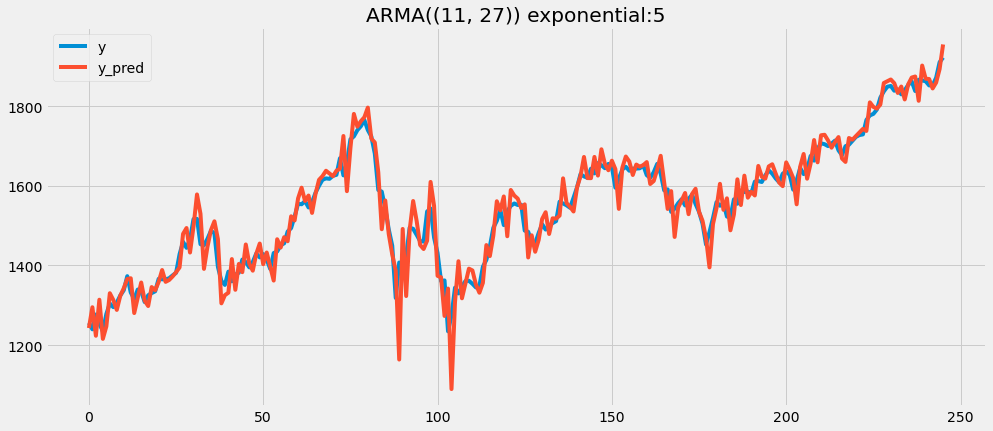

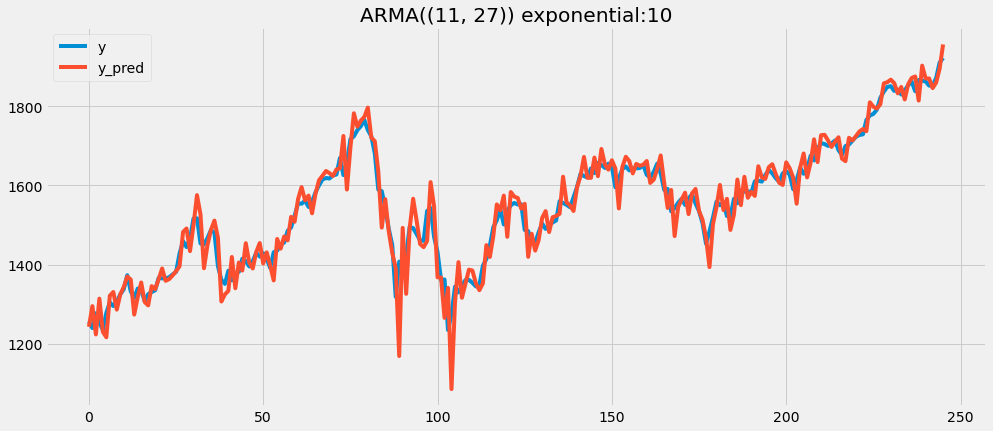

In [71]:
for name, y_pred in zip(models_metrics_2.name, predictions_model_2):
    show_prediction(y_real, y_pred, name)

In [72]:
models_metrics_2.to_excel('result/table_3_2.xls')
predictions_model_aprox_2.to_excel('result/table_3_aprox_2.xls')